## This notebook requires data files generated by running make_simdata_hdf5_database.ipynb

In [1]:
import os
import sys
import tables as pyt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
from matplotlib import ticker
from sklearn import decomposition

#%matplotlib inline  
%matplotlib widget

### Inputs/Paths

In [2]:
# Raw Data, Corrected full
sim_path = "/Users/camerongallivan/Research_Data/Simulation_Data_Py/Trial_0001-py/Analysis/PCA/simdata.h5"
sim_hdf5_path = os.path.join(sim_path)

### Loading simulation data

In [3]:
h5file = pyt.open_file(sim_hdf5_path, mode='a')

In [4]:
prob_2ds = np.asarray(h5file.root.Simulation_Data.prob_2d_vector_array)
sim_probvec_entropies = np.asarray(h5file.root.Simulation_Data.system_probvec_entropies)
sim_prob2d_entropies = np.asarray(h5file.root.Simulation_Data.system_prob2d_entropies)
dimensions = h5file.root.Simulation_Data._v_attrs.dimensions

In [5]:
h5file.close()

### Cleaning Data

In [34]:
# Removing rows with large negative values 
error_mask = (prob_2ds > -1).all(axis=1)
X_multidim = prob_2ds[error_mask]
cleaned_sim_probvec_entropies = sim_probvec_entropies[error_mask]

### Running 2D PCA and prepping for plots

In [25]:
# Initializing Plot inputs dict
plot_inputs = {}
plot_inputs['figshape'] = (14, 8)

In [26]:
# Normal case: Training with simulation data
pca_2d = decomposition.PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(X_multidim)

### Plotting Functions

In [27]:
def plot_2d_pca(pca_2d_result, plot_info, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Creating plot object
    p = ax.scatter(pca_2d_result[:,0], pca_2d_result[:,1], c=plot_info['simdat_color_values'])
    cbar = fig.colorbar(p)

    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()
    
def plot_2d_pca_3_model_entropy(pca_2d_result, plot_info, set_counts, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    zs = np.concatenate(plot_info['simdat_color_values'][:], axis=0)
    min_, max_ = zs.min(), zs.max()
    #markers = ['.','X','s']
    cbar=None
    # Creating plot object
    for i in range(len(set_counts[1:])):
        if cbar is None:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
            cbar = fig.colorbar(s)
        else:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
        
    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()
    
def plot_2d_pca_exp_entropy(pca_2d_result, pca_2d_result_2, plot_info, set_counts, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Creating plot object
    zs = np.concatenate(plot_info['simdat_color_values'][:], axis=0)
    min_, max_ = zs.min(), zs.max()
    
    cbar=None
    # Creating plot object
    for i in range(len(set_counts[1:])):
        if cbar is None:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
            cbar = fig.colorbar(s)
        else:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
    
    if 'simdat_color_values_2' in plot_info.keys():
        p = ax.scatter(pca_2d_result_2[:,0], pca_2d_result_2[:,1], c=plot_info['simdat_color_values_2'], marker='X', s=140)

    else:
        p = ax.scatter(pca_2d_result_2[:,0], pca_2d_result_2[:,1], c='k', marker='X', s=140)

    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()

### Plotting PCA

3 Model simulation plot of normal data, colored by model
Explained variation per principle component: [0.97267753 0.0154295 ]


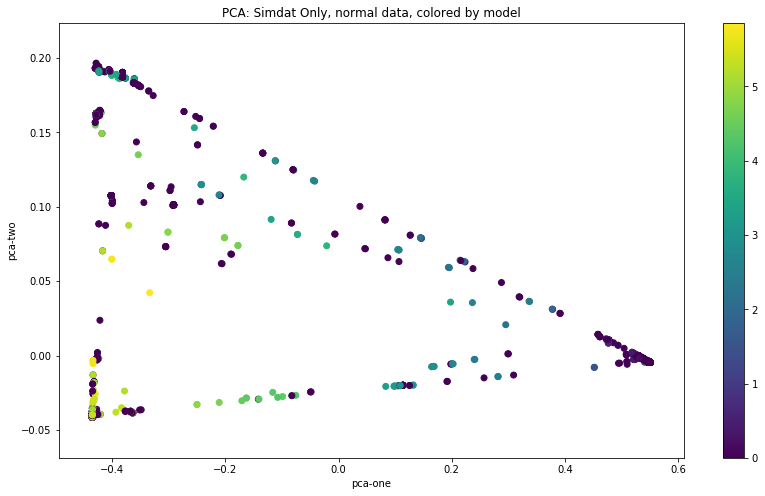

In [36]:
# Plotting just simulation data
print('3 Model simulation plot of normal data, colored by model')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat Only, normal data, colored by model'
plot_inputs['simdat_color_values'] = cleaned_sim_probvec_entropies

plot_2d_pca(pca_2d_result, plot_inputs, save_fig=False)

### Loading alternate simulation data sets

In [42]:
sim_data_2 = "/Users/camerongallivan/Research/Stochastic_GRN_Project/RNA-seq_DataExplore/gene_pair_select"
sim_hdf5_path_2 = os.path.join(sim_data_2, 'outputs', 'simulation_outputs', 'simdata_3_models.h5')

In [47]:
prob_2ds_2 = []
sim_probvec_entropies_2 = []
sim_prob2d_entropies_2 = []
set_counts_2 = [0, ]

In [48]:
h5file = pyt.open_file(sim_hdf5_path_2, mode='a')

for i, group in enumerate(h5file.iter_nodes('/')):
    prob_2ds_2.append(np.asarray(group.prob_2d_vector_array))
    sim_probvec_entropies_2.append(np.asarray(group.system_probvec_entropies))
    sim_prob2d_entropies_2.append(np.asarray(group.system_prob2d_entropies))
    set_counts_2.append(set_counts_2[i]+len(prob_2ds_2[i]))
    #print(group._v_attrs.model_name)

dimensions_2 = group._v_attrs.dimensions
X_multidim_2 = np.concatenate(prob_2ds_2[:], axis=0)

h5file.close()

In [49]:
# Normal case: Training with simulation data
pca_2d_2 = decomposition.PCA(n_components=2)
pca_2d_result_2 = pca_2d.fit_transform(X_multidim_2)

pca_2d_result_2_to_logic = pca_2d.transform(X_multidim)

3 Model simulation plot of normal data, colored by ProbVec entropy
Explained variation per principle component: [0.97216497 0.02709429]


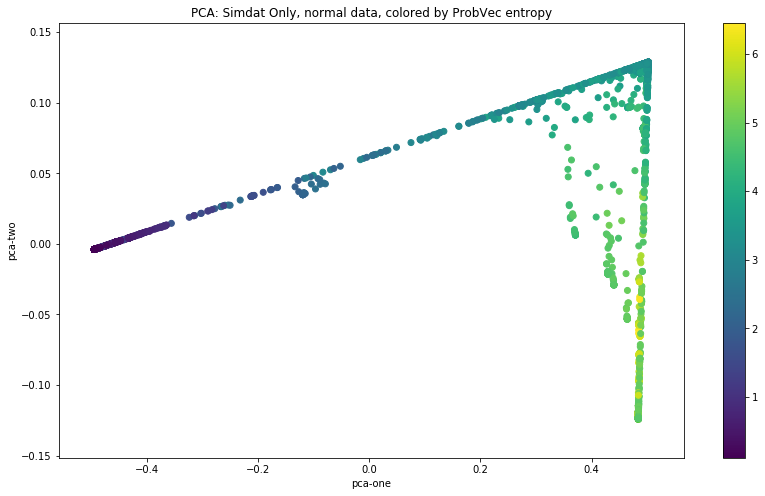

In [71]:
print('3 Model simulation plot of normal data, colored by ProbVec entropy')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat Only, normal data, colored by ProbVec entropy'
plot_inputs['simdat_color_values'] = sim_probvec_entropies_2
plot_2d_pca_3_model_entropy(pca_2d_result_2, plot_inputs, set_counts_2, save_fig=False)

3 Model simulation plot of normal data, colored by model
Explained variation per principle component: [0.97216497 0.02709429]


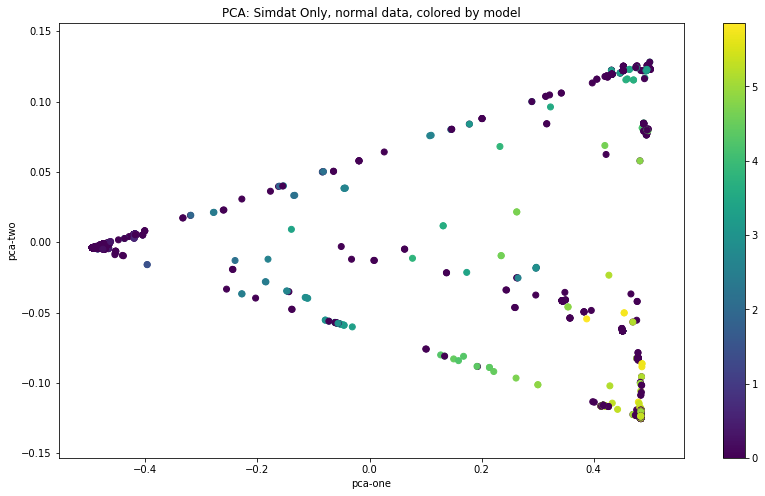

In [75]:
# Plotting just simulation data
print('3 Model simulation plot of normal data, colored by model')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat Only, normal data, colored by model'
plot_inputs['simdat_color_values'] = cleaned_sim_probvec_entropies

plot_2d_pca(pca_2d_result_2_to_logic, plot_inputs, save_fig=False)

3 Model simulation plot of normal data, colored by ProbVec entropy
Explained variation per principle component: [0.97216497 0.02709429]


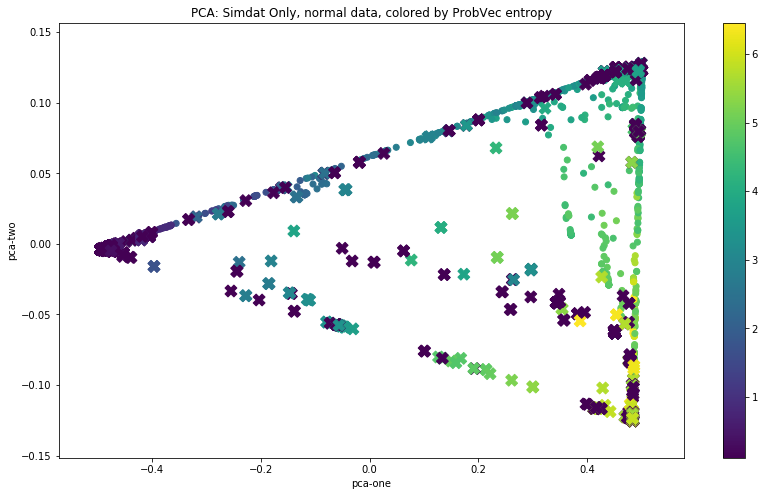

In [70]:
print('3 Model simulation plot of normal data, colored by ProbVec entropy')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat Only, normal data, colored by ProbVec entropy'
plot_inputs['simdat_color_values'] = sim_probvec_entropies_2
plot_inputs['simdat_color_values_2'] = cleaned_sim_probvec_entropies
plot_2d_pca_exp_entropy(pca_2d_result_2, pca_2d_result_2_to_logic, plot_inputs, set_counts_2, save_fig=False)

### Checking GRN Logic

In [19]:
import itertools
g_names = ['g0', 'g1']
header_1 = ['', 'A_00', 'A_01', 'A_10', 'A_11', '', 'B_00', 'B_01', 'B_10', 'B_11']
header_2 = ['', 'BA', 'BA', 'BA', 'BA', '', 'AB', 'AB', 'AB', 'AB']

variedLogicMatrix = list(itertools.product(g_names, repeat=4))

print('  | '.join(str(x).rjust(4) for x in header_2))
print('  | '.join(str(x).rjust(4) for x in header_1))

for i, row in enumerate(variedLogicMatrix):
    mod_row = (i+1,) + row + ('',) + row
    print('  | '.join(str(x).rjust(4) for x in mod_row))

      |   BA  |   BA  |   BA  |   BA  |       |   AB  |   AB  |   AB  |   AB
      | A_00  | A_01  | A_10  | A_11  |       | B_00  | B_01  | B_10  | B_11
   1  |   g0  |   g0  |   g0  |   g0  |       |   g0  |   g0  |   g0  |   g0
   2  |   g0  |   g0  |   g0  |   g1  |       |   g0  |   g0  |   g0  |   g1
   3  |   g0  |   g0  |   g1  |   g0  |       |   g0  |   g0  |   g1  |   g0
   4  |   g0  |   g0  |   g1  |   g1  |       |   g0  |   g0  |   g1  |   g1
   5  |   g0  |   g1  |   g0  |   g0  |       |   g0  |   g1  |   g0  |   g0
   6  |   g0  |   g1  |   g0  |   g1  |       |   g0  |   g1  |   g0  |   g1
   7  |   g0  |   g1  |   g1  |   g0  |       |   g0  |   g1  |   g1  |   g0
   8  |   g0  |   g1  |   g1  |   g1  |       |   g0  |   g1  |   g1  |   g1
   9  |   g1  |   g0  |   g0  |   g0  |       |   g1  |   g0  |   g0  |   g0
  10  |   g1  |   g0  |   g0  |   g1  |       |   g1  |   g0  |   g0  |   g1
  11  |   g1  |   g0  |   g1  |   g0  |       |   g1  |   g0  |   g1  |   g0